<a href="https://colab.research.google.com/github/bautista3383/Ventas_Retail/blob/main/Ventas_Retail_Final_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Análisis y Modelado de Ventas
Random Forest Regressor


Análisis desde la carga hasta la evaluación de un modelo avanzado (Random Forest) para predecir total_venta y venta_unidades.
"""

# --- 0. Importación de Librerías ---
print("--- 0. Importando librerías ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Se importa el modelo Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

# Se desactivan advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Se configura el estilo de las gráficas
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Librerías instaladas-")

# Instalación de la librería oficial de Kaggle (la -q es para que no muestre tanto texto)
!pip install kaggle -q
# Importación de la utilidad de archivos de Colab
from google.colab import files

# Diálogo para seleccionar el archivo
print('Sube tu archivo kaggle.json:')
files.upload()
# Creación de la carpeta oculta .kaggle donde la librería busca el API token
!mkdir -p ~/.kaggle

# Copia del archivo subido a esa carpeta
!cp kaggle.json ~/.kaggle/

# Asignación de los permisos correctos al archivo
!chmod 600 ~/.kaggle/kaggle.json
# Descarga del dataset usando su "slug": tevecsystems/retail-sales-forecasting
!kaggle datasets download -d tevecsystems/retail-sales-forecasting
# Descompresión del archivo .zip descargado
!unzip retail-sales-forecasting.zip
# Lista de los archivos para confirmar que 'mock_kaggle.csv' está ahí
!ls

--- 0. Importando librerías ---
Librerías instaladas-
Sube tu archivo kaggle.json:


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/tevecsystems/retail-sales-forecasting
License(s): CC-BY-NC-SA-4.0
retail-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  retail-sales-forecasting.zip
replace mock_kaggle.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mock_kaggle.csv         
'kaggle (1).json'	        RF_1_ts_predicciones_comparadas.png
 kaggle.json		        RF_2_agg_dia_mes_predicciones.png
 mock_kaggle.csv	        RF_3_feature_importances.png
 retail-sales-forecasting.zip   sample_data


In [ ]:
# --- 1. Carga y EDA Inicial ---
print("\n--- 1. Carga y EDA Inicial ---")
try:
    df = pd.read_csv('mock_kaggle.csv')
    print("Dataset 'mock_kaggle.csv' cargado exitosamente.")
except FileNotFoundError:
    print("Error: No se pudo encontrar el archivo 'mock_kaggle.csv'.")
    exit()

# Se muestra un resumen estadístico inicial
print("\nResumen estadístico inicial (df.describe()):")
print(df.describe())
print("\nValores nulos iniciales (df.isnull().sum()):")
print(df.isnull().sum())


--- 1. Carga y EDA Inicial ---
Dataset 'mock_kaggle.csv' cargado exitosamente.

Resumen estadístico inicial (df.describe()):
       venda  estoque  preco
count 937.00   937.00 937.00
mean   90.53  1608.26   1.59
std    80.68  1356.69   0.53
min     0.00     0.00   0.00
25%    33.00   794.00   1.29
50%    76.00  1348.00   1.39
75%   127.00  1964.00   1.89
max   542.00  7228.00   2.98

Valores nulos iniciales (df.isnull().sum()):
data       0
venda      0
estoque    0
preco      0
dtype: int64


In [ ]:
# --- 2. Limpieza, Preprocesamiento y Creación de Variables ---
print("\n--- 2. Limpieza, Preprocesamiento y Creación de Variables ---")
df_clean = df.copy()

# Se renombran las columnas
columnas_nuevas = {
    'data': 'fecha',
    'venda': 'venta_unidades',
    'estoque': 'stock',
    'preco': 'precio'
}
df_clean = df_clean.rename(columns=columnas_nuevas)
print(f"Columnas renombradas a: {list(df_clean.columns)}")

# Se infiere el formato de fecha (YYYY-MM-DD)
df_clean['fecha'] = pd.to_datetime(df_clean['fecha'], errors='coerce')
df_clean = df_clean.dropna(subset=['fecha'])
df_clean = df_clean.sort_values(by='fecha').reset_index(drop=True)
print("Columna 'fecha' convertida a datetime exitosamente.")

# Se crea la columna 'total_venta'
df_clean['total_venta'] = df_clean['venta_unidades'] * df_clean['precio']
print("Columna 'total_venta' creada.")

# --- Manejo de Atípicos (Solo Negativos) ---
# Random Forest es robusto a los outliers altos, por lo que NO se
# aplica el recorte IQR. Solo se aseguran los mínimos lógicos (0).
print("\nAjustando solo valores negativos a 0...")
columnas_numericas = ['venta_unidades', 'stock', 'precio', 'total_venta']
for col in columnas_numericas:
    df_clean[col] = np.clip(df_clean[col], 0, None)
print("Valores negativos (si los hubo) ajustados a 0.")

# --- Manejo de Valores Nulos ---
if df_clean.isnull().sum().any():
    print("\nDetectados valores nulos. Se aplicará 'forward fill' (ffill)...")
    df_clean = df_clean.ffill()
else:
    print("\nNo se encontraron valores nulos en el dataset.")


--- 2. Limpieza, Preprocesamiento y Creación de Variables ---
Columnas renombradas a: ['fecha', 'venta_unidades', 'stock', 'precio']
Columna 'fecha' convertida a datetime exitosamente.
Columna 'total_venta' creada.

Ajustando solo valores negativos a 0...
Valores negativos (si los hubo) ajustados a 0.

No se encontraron valores nulos en el dataset.


In [ ]:
# --- 3. Ingeniería de Variables de Tiempo ---
print("\n--- 3. Ingeniería de Variables de Tiempo ---")
df_clean['dia_semana'] = df_clean['fecha'].dt.dayofweek + 1
df_clean['num_semana_ano'] = df_clean['fecha'].dt.isocalendar().week.astype(int)
df_clean['mes'] = df_clean['fecha'].dt.month
df_clean['ano'] = df_clean['fecha'].dt.year

# Se crean nombres para los gráficos
nombres_meses = {1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'}
nombres_dias = {1: 'Lun', 2: 'Mar', 3: 'Mié', 4: 'Jue', 5: 'Vie', 6: 'Sáb', 7: 'Dom'}
df_clean['nombre_mes'] = df_clean['mes'].map(nombres_meses)
df_clean['nombre_dia'] = df_clean['dia_semana'].map(nombres_dias)
meses_ordenados = list(nombres_meses.values())
dias_ordenados = list(nombres_dias.values())
print("Variables de tiempo creadas.")


--- 3. Ingeniería de Variables de Tiempo ---
Variables de tiempo creadas.


In [ ]:
# --- 4. EDA Post-Limpieza y Visualización ---
# (Esta sección es opcional, pero se mantiene para consistencia)
print("\n--- 4. EDA Post-Limpieza y Visualización ---")
print("\nResumen estadístico post-limpieza (df_clean.describe()):")
print(df_clean.describe(include=[np.number]))


--- 4. EDA Post-Limpieza y Visualización ---

Resumen estadístico post-limpieza (df_clean.describe()):
       venta_unidades   stock  precio  total_venta  dia_semana  \
count          937.00  937.00  937.00       937.00      937.00   
mean            90.53 1608.26    1.59       148.23        4.01   
std             80.68 1356.69    0.53       144.30        2.00   
min              0.00    0.00    0.00         0.00        1.00   
25%             33.00  794.00    1.29        52.32        2.00   
50%             76.00 1348.00    1.39       112.23        4.00   
75%            127.00 1964.00    1.89       207.10        6.00   
max            542.00 7228.00    2.98       870.24        7.00   

       num_semana_ano    mes     ano  
count          937.00 937.00  937.00  
mean            24.38   5.98 2014.84  
std             14.71   3.35    0.77  
min              1.00   1.00 2014.00  
25%             12.00   3.00 2014.00  
50%             23.00   6.00 2015.00  
75%             36.00   9.00

In [ ]:
# --- 5. Ingeniería de Variables (Lags) para Modelado ---
print("\n--- 5. Ingeniería de Variables (Lags) para Modelado ---")
# Se usan los lags de 7 días para preservar la mayor cantidad de datos
print("Generando lags (1, 7 días) y medias móviles (7 días)...")

df_clean['total_venta_lag_1'] = df_clean['total_venta'].shift(1)
df_clean['total_venta_lag_7'] = df_clean['total_venta'].shift(7)
df_clean['venta_unidades_lag_1'] = df_clean['venta_unidades'].shift(1)
df_clean['venta_unidades_lag_7'] = df_clean['venta_unidades'].shift(7)

df_clean['total_venta_roll_7'] = df_clean['total_venta'].shift(1).rolling(window=7).mean()
df_clean['venta_unidades_roll_7'] = df_clean['venta_unidades'].shift(1).rolling(window=7).mean()
df_clean['precio_roll_7'] = df_clean['precio'].shift(1).rolling(window=7).mean()
df_clean['stock_roll_7'] = df_clean['stock'].shift(1).rolling(window=7).mean()

# Se eliminan los valores NaN creados por los lags
df_model = df_clean.dropna()
print(f"Dataset listo para modelado. Se eliminaron {len(df_clean) - len(df_model)} filas con NaNs.")
print(f"Tamaño del dataset para modelado: {df_model.shape}")


--- 5. Ingeniería de Variables (Lags) para Modelado ---
Generando lags (1, 7 días) y medias móviles (7 días)...
Dataset listo para modelado. Se eliminaron 7 filas con NaNs.
Tamaño del dataset para modelado: (930, 19)


In [ ]:
# --- 6. Preprocesamiento y Entrenamiento (Random Forest Sin Restricciones) ---
print("\n--- 6. Preprocesamiento y Entrenamiento (Random Forest Sin Restricciones) ---")

# --- 6.1 Preprocesamiento ---
print("Preparando datos para el modelo...")

# Se definen las variables predictoras (X)
features = [
    'dia_semana', 'num_semana_ano', 'mes', 'ano',
    'precio', 'stock',
    'precio_roll_7', 'stock_roll_7',
    'total_venta_lag_1', 'total_venta_lag_7', 'total_venta_roll_7',
    'venta_unidades_lag_1', 'venta_unidades_lag_7', 'venta_unidades_roll_7'
]
# Se definen los dos targets (y)
target_tv = 'total_venta'
target_vu = 'venta_unidades'

features_presentes = [col for col in features if col in df_model.columns]
X = df_model[features_presentes]
y_tv = df_model[target_tv]
y_vu = df_model[target_vu]

print(f"Se usarán {len(features_presentes)} variables predictoras.")

# División de datos (train/test)
X_train, X_test, y_tv_train, y_tv_test, y_vu_train, y_vu_test = train_test_split(
    X, y_tv, y_vu, test_size=0.2, shuffle=False # shuffle=False es crucial
)

print(f"Tamaño de datos de entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño de datos de prueba: {X_test.shape[0]} filas")


--- 6. Preprocesamiento y Entrenamiento (Random Forest Sin Restricciones) ---
Preparando datos para el modelo...
Se usarán 14 variables predictoras.
Tamaño de datos de entrenamiento: 744 filas
Tamaño de datos de prueba: 186 filas


In [ ]:
# --- 6.2 Entrenamiento ---

# Modelo 1: total_venta
print("\nEntrenando Modelo 1 (Random Forest para total_venta)...")
# --- Se eliminan 'max_depth' y 'min_samples_leaf' ---
# Se permite que los árboles crezcan a su máxima profundidad para
# capturar todos los patrones complejos, incluidos outliers y ceros.
model_tv = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_tv.fit(X_train, y_tv_train)
print("Modelo 1 (total_venta) entrenado.")

# Modelo 2: venta_unidades
print("Entrenando Modelo 2 (Random Forest para venta_unidades)...")
# --- Se eliminan 'max_depth' y 'min_samples_leaf' ---
model_vu = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_vu.fit(X_train, y_vu_train)
print("Modelo 2 (venta_unidades) entrenado.")


Entrenando Modelo 1 (Random Forest para total_venta)...
Modelo 1 (total_venta) entrenado.
Entrenando Modelo 2 (Random Forest para venta_unidades)...
Modelo 2 (venta_unidades) entrenado.


In [ ]:
# --- 6.3 Evaluación ---
print("\nEvaluando modelos...")

# Predicciones de ambos modelos
y_pred_tv = model_tv.predict(X_test)
y_pred_vu = model_vu.predict(X_test)

# Métricas para total_venta
print("\n--- Métricas de Desempeño (Modelo total_venta) ---")
mae_tv = mean_absolute_error(y_tv_test, y_pred_tv)
rmse_tv = np.sqrt(mean_squared_error(y_tv_test, y_pred_tv))
r2_tv = r2_score(y_tv_test, y_pred_tv)
print(f"MAE (total_venta):   {mae_tv:.2f}")
print(f"RMSE (total_venta):  {rmse_tv:.2f}")
print(f"R² (total_venta):    {r2_tv:.4f}")

# Métricas para venta_unidades
print("\n--- Métricas de Desempeño (Modelo venta_unidades) ---")
mae_vu = mean_absolute_error(y_vu_test, y_pred_vu)
rmse_vu = np.sqrt(mean_squared_error(y_vu_test, y_pred_vu))
r2_vu = r2_score(y_vu_test, y_pred_vu)
print(f"MAE (venta_unidades):   {mae_vu:.2f}")
print(f"RMSE (venta_unidades):  {rmse_vu:.2f}")
print(f"R² (venta_unidades):    {r2_vu:.4f}")


Evaluando modelos...

--- Métricas de Desempeño (Modelo total_venta) ---
MAE (total_venta):   105.83
RMSE (total_venta):  143.67
R² (total_venta):    0.3571

--- Métricas de Desempeño (Modelo venta_unidades) ---
MAE (venta_unidades):   50.83
RMSE (venta_unidades):  66.58
R² (venta_unidades):    0.4520



--- 7. Visualización de Resultados del Modelo ---
Generando gráficos de serie temporal (Predicción vs Real)...
Gráfica 'RF_Full_1_ts_predicciones.png' guardada.
Generando gráficos agregados (Por Día de Semana y Mes)...
Gráfica 'RF_Full_2_agg_dia_mes.png' guardada.


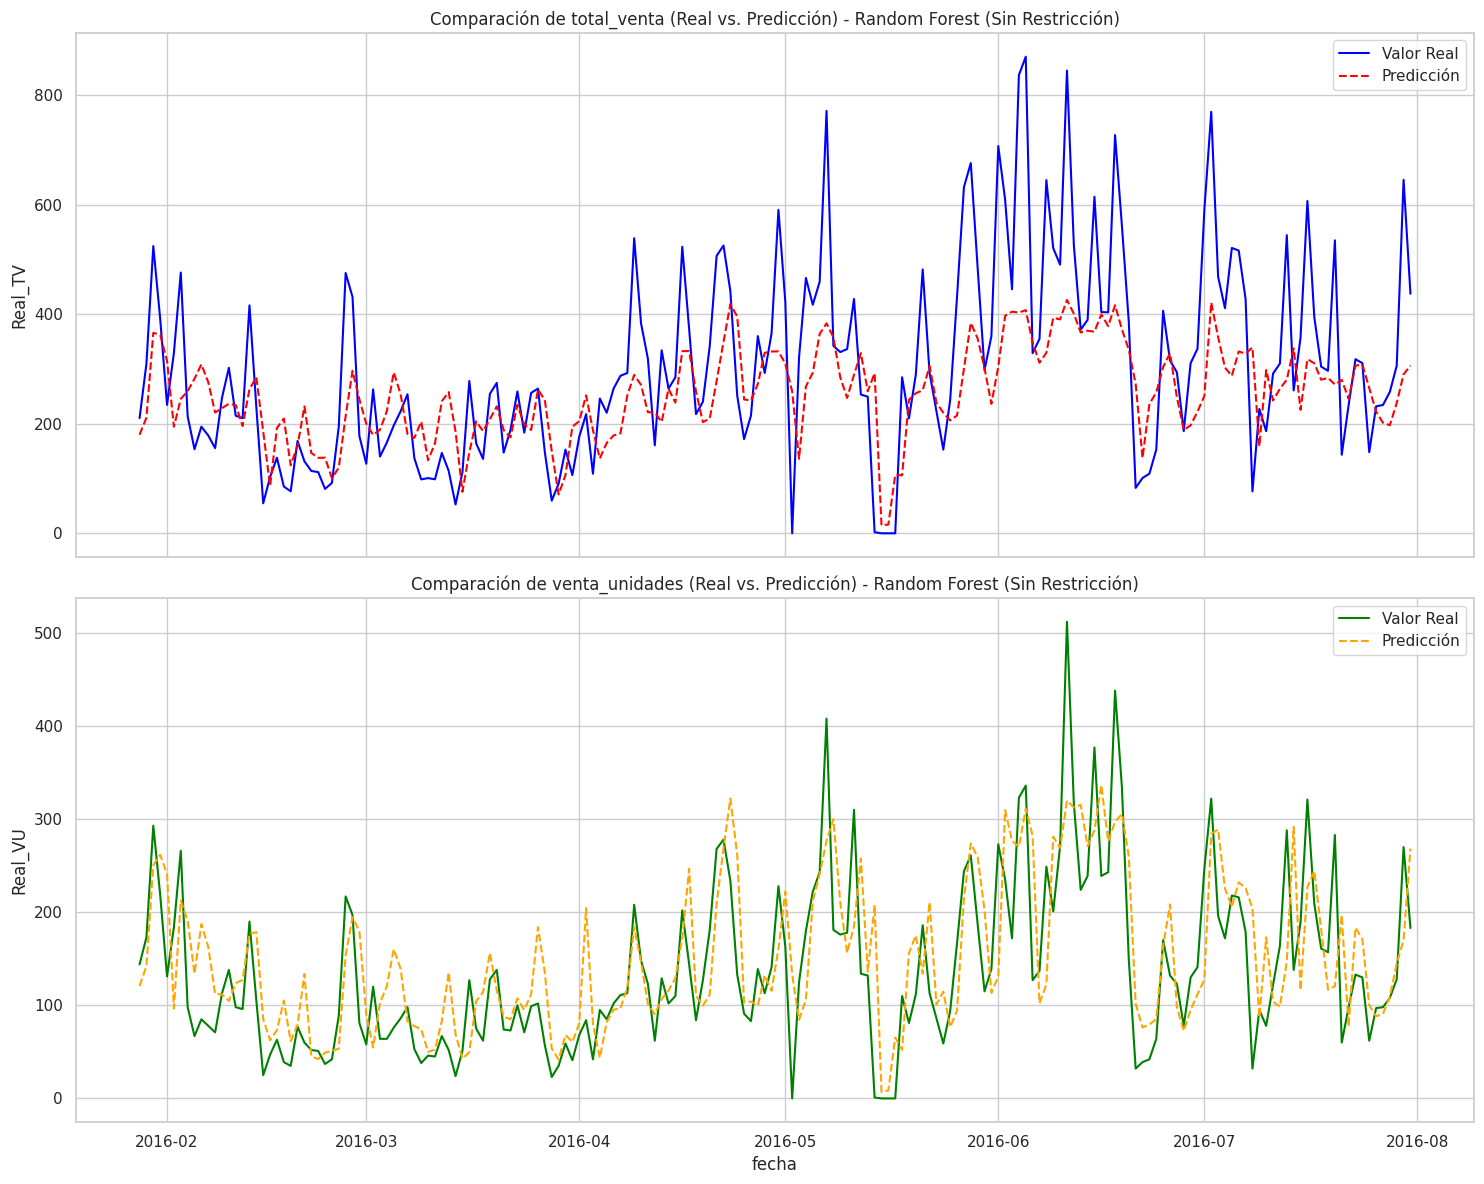

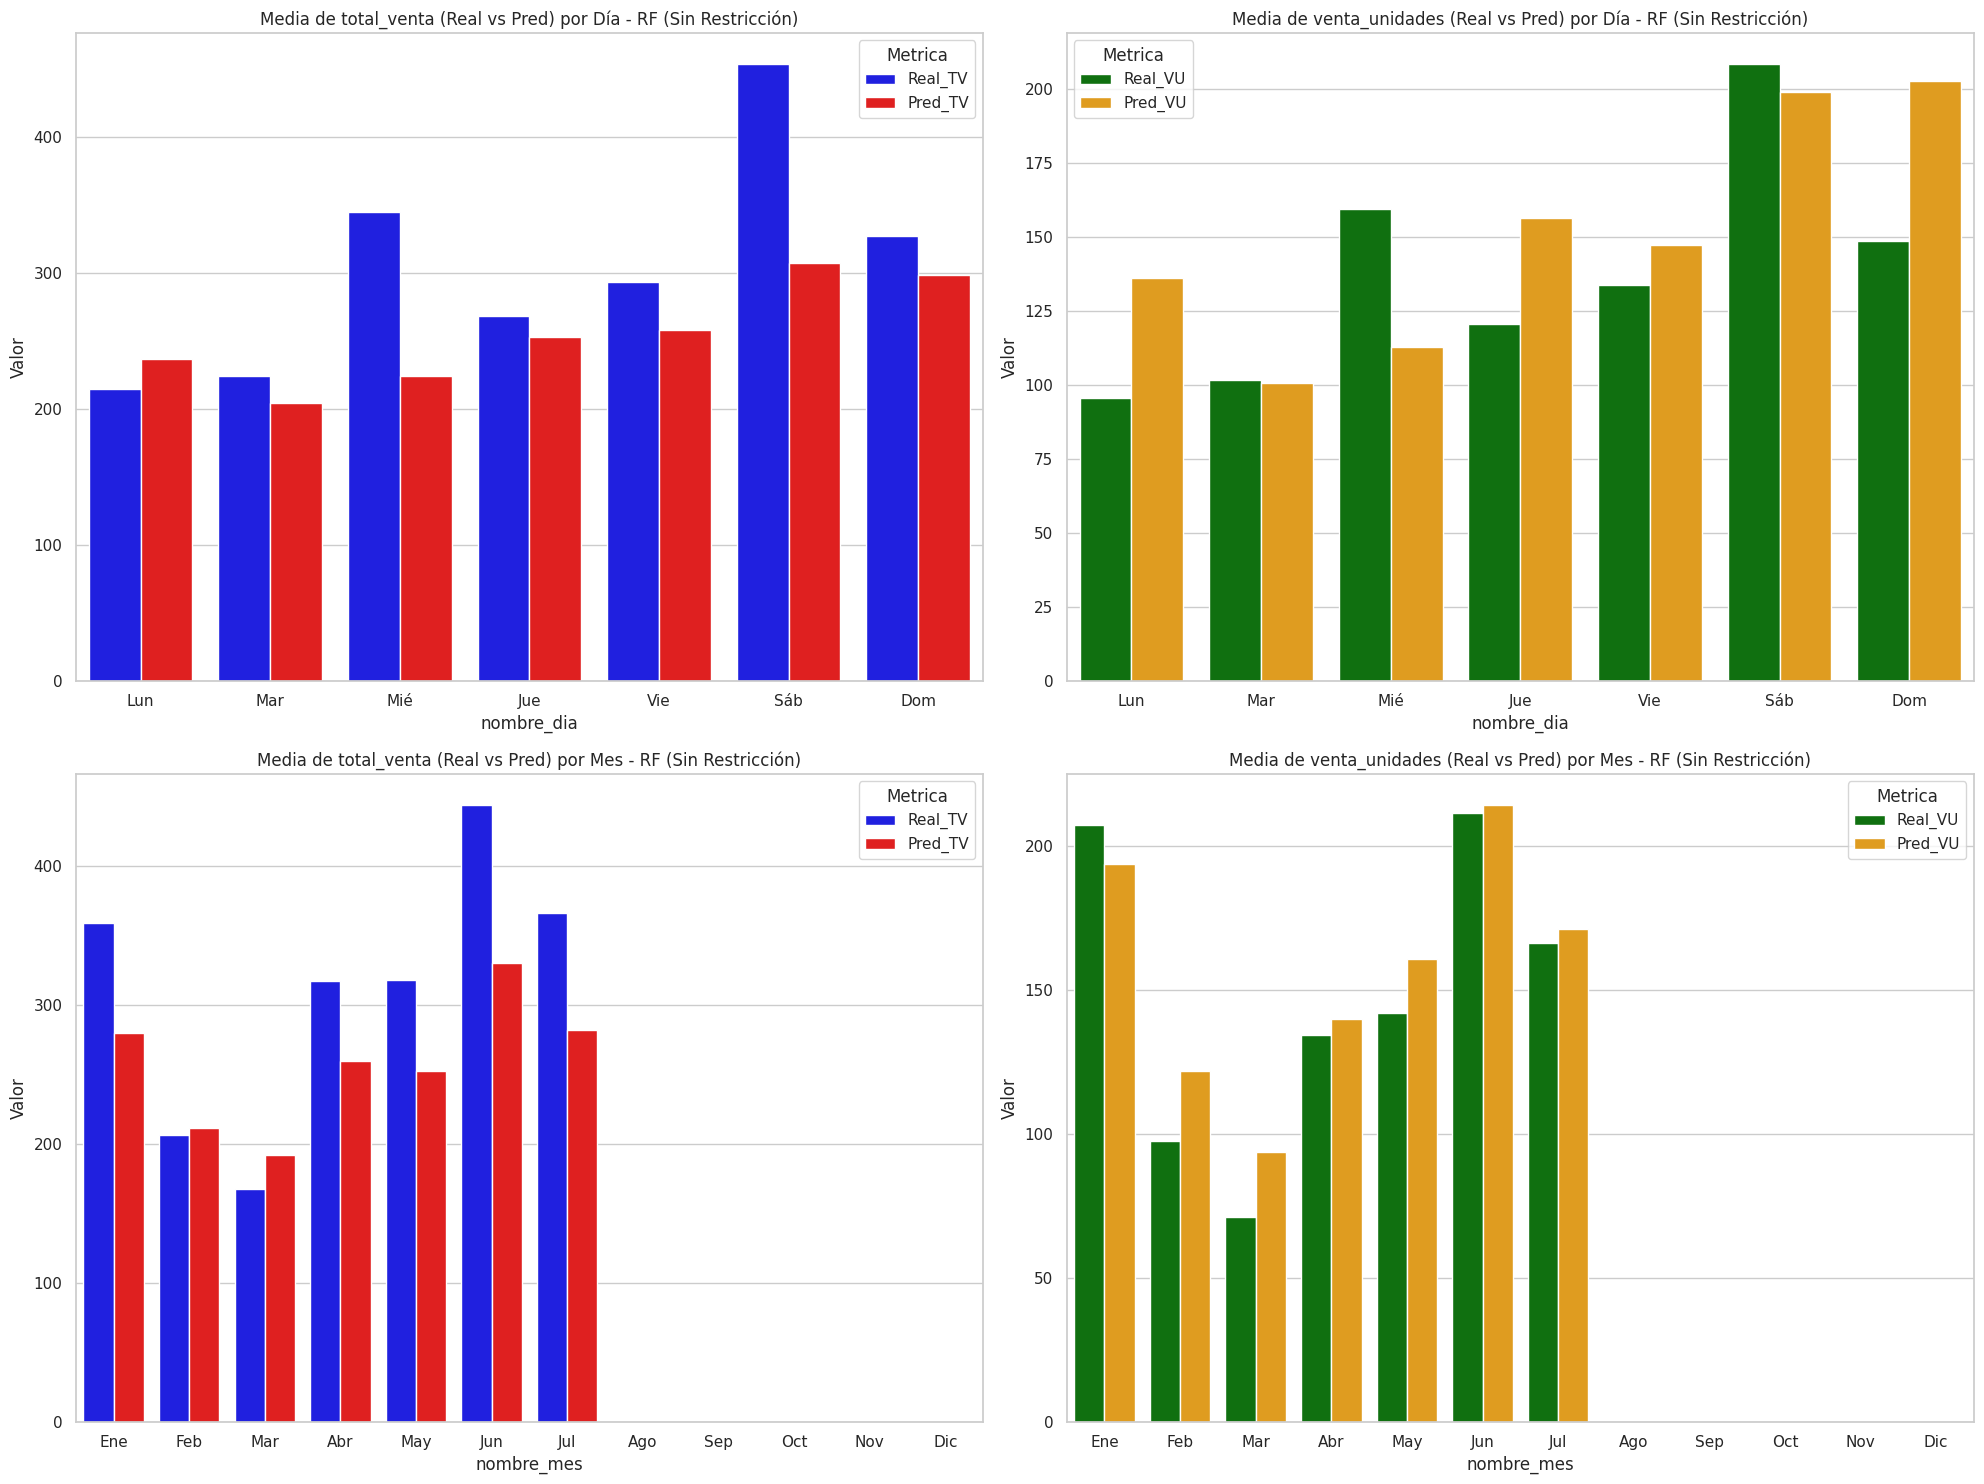

In [ ]:
# --- 7. Visualización de Resultados del Modelo ---
print("\n--- 7. Visualización de Resultados del Modelo ---")

# Se crea un DataFrame central con todos los resultados
results_df = df_model.loc[X_test.index, ['fecha', 'nombre_dia', 'nombre_mes', 'num_semana_ano']].copy()
results_df['Real_TV'] = y_tv_test
results_df['Pred_TV'] = y_pred_tv
results_df['Real_VU'] = y_vu_test
results_df['Pred_VU'] = y_pred_vu

# --- Gráficos por Fecha (Series Temporales) ---
print("Generando gráficos de serie temporal (Predicción vs Real)...")
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
sns.lineplot(data=results_df, x='fecha', y='Real_TV', label='Valor Real', color='blue', ax=axes[0])
sns.lineplot(data=results_df, x='fecha', y='Pred_TV', label='Predicción', color='red', linestyle='--', ax=axes[0])
axes[0].set_title('Comparación de total_venta (Real vs. Predicción) - Random Forest (Sin Restricción)')
sns.lineplot(data=results_df, x='fecha', y='Real_VU', label='Valor Real', color='green', ax=axes[1])
sns.lineplot(data=results_df, x='fecha', y='Pred_VU', label='Predicción', color='orange', linestyle='--', ax=axes[1])
axes[1].set_title('Comparación de venta_unidades (Real vs. Predicción) - Random Forest (Sin Restricción)')
plt.tight_layout()
plt.savefig('RF_Full_1_ts_predicciones.png')
print("Gráfica 'RF_Full_1_ts_predicciones.png' guardada.")

# --- Gráficos Agregados (Día y Mes) ---
print("Generando gráficos agregados (Por Día de Semana y Mes)...")
agg_dia = results_df.groupby('nombre_dia')[['Real_TV', 'Pred_TV', 'Real_VU', 'Pred_VU']].mean().reindex(dias_ordenados)
agg_mes = results_df.groupby('nombre_mes')[['Real_TV', 'Pred_TV', 'Real_VU', 'Pred_VU']].mean().reindex(meses_ordenados)
agg_dia_melt = agg_dia.reset_index().melt('nombre_dia', var_name='Metrica', value_name='Valor')
agg_mes_melt = agg_mes.reset_index().melt('nombre_mes', var_name='Metrica', value_name='Valor')

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.barplot(data=agg_dia_melt[agg_dia_melt['Metrica'].isin(['Real_TV', 'Pred_TV'])], x='nombre_dia', y='Valor', hue='Metrica', ax=axes[0, 0], palette={'Real_TV': 'blue', 'Pred_TV': 'red'})
axes[0, 0].set_title('Media de total_venta (Real vs Pred) por Día - RF (Sin Restricción)')
sns.barplot(data=agg_dia_melt[agg_dia_melt['Metrica'].isin(['Real_VU', 'Pred_VU'])], x='nombre_dia', y='Valor', hue='Metrica', ax=axes[0, 1], palette={'Real_VU': 'green', 'Pred_VU': 'orange'})
axes[0, 1].set_title('Media de venta_unidades (Real vs Pred) por Día - RF (Sin Restricción)')
sns.barplot(data=agg_mes_melt[agg_mes_melt['Metrica'].isin(['Real_TV', 'Pred_TV'])], x='nombre_mes', y='Valor', hue='Metrica', ax=axes[1, 0], palette={'Real_TV': 'blue', 'Pred_TV': 'red'})
axes[1, 0].set_title('Media de total_venta (Real vs Pred) por Mes - RF (Sin Restricción)')
sns.barplot(data=agg_mes_melt[agg_mes_melt['Metrica'].isin(['Real_VU', 'Pred_VU'])], x='nombre_mes', y='Valor', hue='Metrica', ax=axes[1, 1], palette={'Real_VU': 'green', 'Pred_VU': 'orange'})
axes[1, 1].set_title('Media de venta_unidades (Real vs Pred) por Mes - RF (Sin Restricción)')
plt.tight_layout()
plt.savefig('RF_Full_2_agg_dia_mes.png')
print("Gráfica 'RF_Full_2_agg_dia_mes.png' guardada.")

In [ ]:
# --- 8. Casos de Prueba Aleatorios (5 por Período) ---
print("\n--- 8. Casos de Prueba Aleatorios (5 por Período) ---")
agg_sem = results_df.groupby('num_semana_ano')[['Real_TV', 'Pred_TV', 'Real_VU', 'Pred_VU']].mean()

# --- Predicciones para total_venta ---
print("\n--- Casos de Prueba: total_venta ---")
print("\nPor Fecha (5 casos diarios aleatorios del Test Set):")
print(results_df.sample(5, random_state=1)[['fecha', 'Real_TV', 'Pred_TV']].to_string(index=False))
print("\nPor Día de la Semana (5 casos aleatorios, media del Test Set):")
print(agg_dia.sample(5, random_state=1)[['Real_TV', 'Pred_TV']])
print("\nPor Semana del Año (5 casos aleatorios, media del Test Set):")
print(agg_sem.sample(5, random_state=1)[['Real_TV', 'Pred_TV']])
print("\nPor Mes (5 casos aleatorios, media del Test Set):")
print(agg_mes.sample(5, random_state=1)[['Real_TV', 'Pred_TV']])

# --- Predicciones para venta_unidades ---
print("\n\n--- Casos de Prueba: venta_unidades ---")
print("\nPor Fecha (5 casos diarios aleatorios del Test Set):")
print(results_df.sample(5, random_state=2)[['fecha', 'Real_VU', 'Pred_VU']].to_string(index=False))
print("\nPor Día de la Semana (5 casos aleatorios, media del Test Set):")
print(agg_dia.sample(5, random_state=2)[['Real_VU', 'Pred_VU']])
print("\nPor Semana del Año (5 casos aleatorios, media del Test Set):")
print(agg_sem.sample(5, random_state=2)[['Real_VU', 'Pred_VU']])
print("\nPor Mes (5 casos aleatorios, media del Test Set):")
print(agg_mes.sample(5, random_state=2)[['Real_VU', 'Pred_VU']])


--- 8. Casos de Prueba Aleatorios (5 por Período) ---

--- Casos de Prueba: total_venta ---

Por Fecha (5 casos diarios aleatorios del Test Set):
     fecha  Real_TV  Pred_TV
2016-02-13   416.10   263.06
2016-07-26   231.83   222.24
2016-04-03   108.78   188.04
2016-03-08   137.27   174.23
2016-07-13   544.32   280.56

Por Día de la Semana (5 casos aleatorios, media del Test Set):
            Real_TV  Pred_TV
nombre_dia                  
Dom          327.81   298.51
Mié          345.35   224.61
Mar          224.10   204.66
Lun          215.02   237.20
Vie          293.81   258.55

Por Semana del Año (5 casos aleatorios, media del Test Set):
                Real_TV  Pred_TV
num_semana_ano                  
21               406.26   274.34
18               396.76   294.49
22               589.41   350.61
7                108.25   169.96
27               338.01   292.33

Por Mes (5 casos aleatorios, media del Test Set):
            Real_TV  Pred_TV
nombre_mes                  
Mar       



--- 9. Importancia de Variables (Feature Importance) ---

Variables más importantes para predecir 'total_venta':
             Variable  Importancia
    total_venta_lag_1         0.41
    total_venta_lag_7         0.08
        precio_roll_7         0.07
 venta_unidades_lag_1         0.06
   total_venta_roll_7         0.06
           dia_semana         0.06
                stock         0.05
         stock_roll_7         0.05
venta_unidades_roll_7         0.05
 venta_unidades_lag_7         0.04

Variables más importantes para predecir 'venta_unidades':
             Variable  Importancia
 venta_unidades_lag_1         0.43
    total_venta_lag_7         0.07
           dia_semana         0.07
    total_venta_lag_1         0.06
         stock_roll_7         0.06
venta_unidades_roll_7         0.05
   total_venta_roll_7         0.05
                stock         0.05
        precio_roll_7         0.05
 venta_unidades_lag_7         0.04
Gráfica 'RF_Full_3_feature_importances.png' guardada.

-

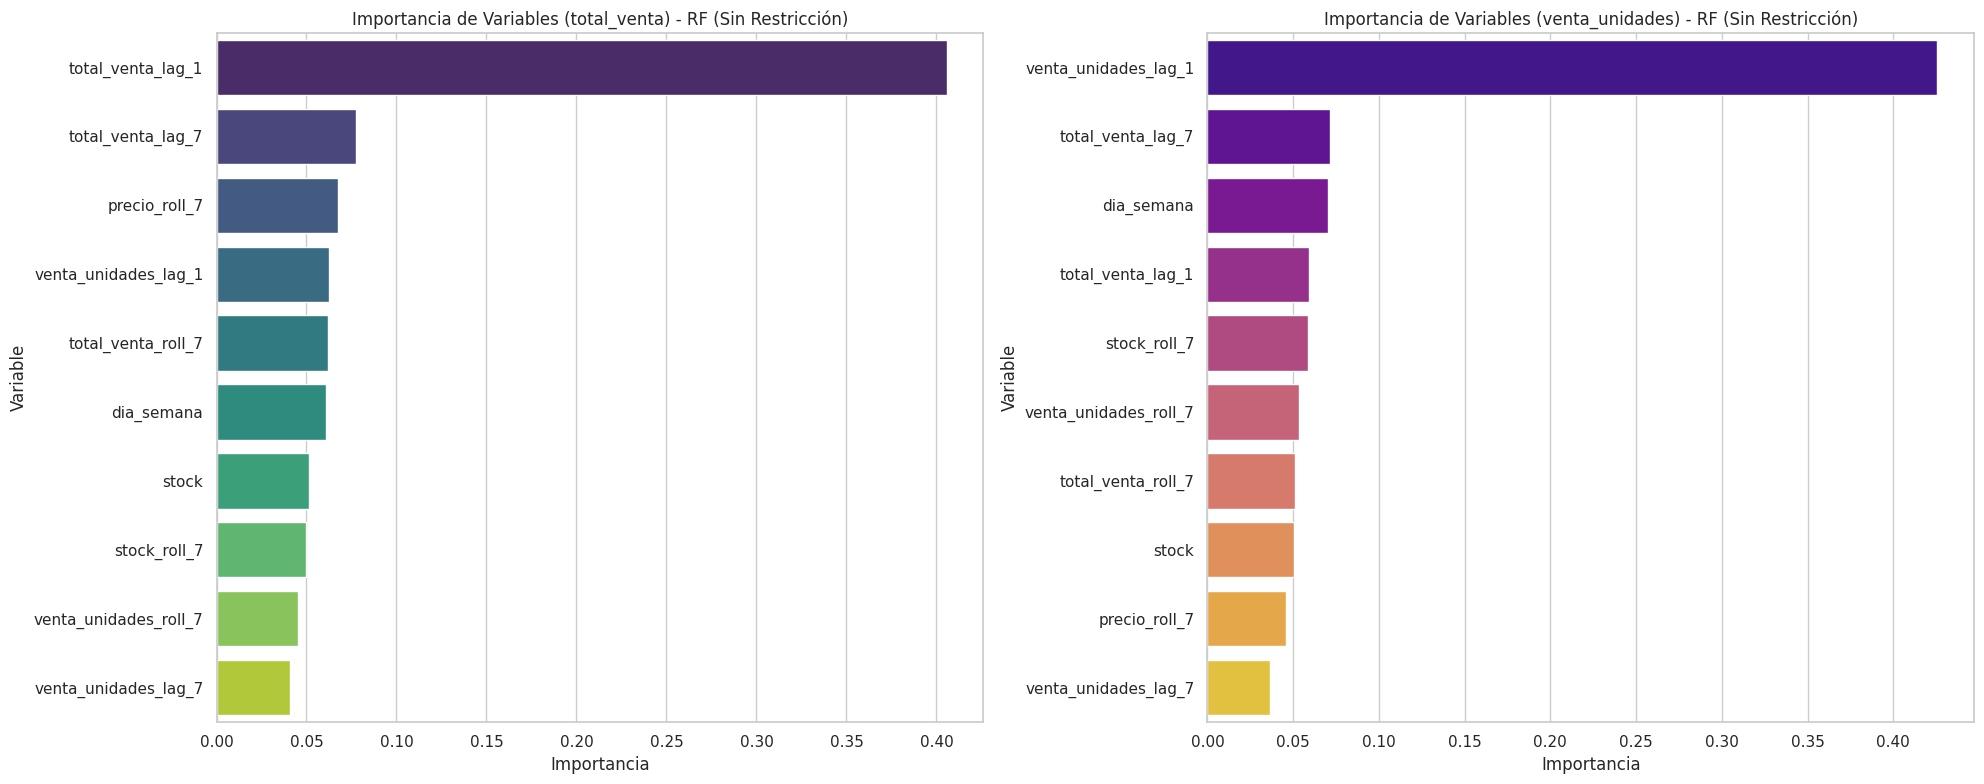

In [ ]:
# --- 9. Característica Adicional: Importancia de Variables ---
print("\n\n--- 9. Importancia de Variables (Feature Importance) ---")
# Se analiza qué variables consideró más importantes el modelo

# Para total_venta
importances_tv = model_tv.feature_importances_
df_importances_tv = pd.DataFrame({
    'Variable': features_presentes,
    'Importancia': importances_tv
}).sort_values(by='Importancia', ascending=False)

print("\nVariables más importantes para predecir 'total_venta':")
print(df_importances_tv.head(10).to_string(index=False))

# Para venta_unidades
importances_vu = model_vu.feature_importances_
df_importances_vu = pd.DataFrame({
    'Variable': features_presentes,
    'Importancia': importances_vu
}).sort_values(by='Importancia', ascending=False)

print("\nVariables más importantes para predecir 'venta_unidades':")
print(df_importances_vu.head(10).to_string(index=False))

# Se genera gráfica de importancia
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(data=df_importances_tv.head(10), x='Importancia', y='Variable', ax=axes[0], palette='viridis')
axes[0].set_title('Importancia de Variables (total_venta) - RF (Sin Restricción)')
sns.barplot(data=df_importances_vu.head(10), x='Importancia', y='Variable', ax=axes[1], palette='plasma')
axes[1].set_title('Importancia de Variables (venta_unidades) - RF (Sin Restricción)')
plt.tight_layout()
plt.savefig('RF_Full_3_feature_importances.png')
print("Gráfica 'RF_Full_3_feature_importances.png' guardada.")

print("\n--- Análisis Completado Exitosamente con Random Forest ---")